In [1]:

import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/input2/farm_insects/Citrus Canker/Image_22.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_53.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_37.png
/kaggle/input/input2/farm_insects/Citrus Canker/Image_69.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_68.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_51.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_75.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_12.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_16.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_72.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_58.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_62.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_2.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_110.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_7.jpg
/kaggle/input/input2/farm_insects/Citrus Canker/Image_107.jpg
/kaggle/input/input2/far

Found 1591 files belonging to 15 classes.
Using 1273 files for training.
Found 1591 files belonging to 15 classes.
Using 318 files for validation.
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.1556 - loss: 2.6632 - val_accuracy: 0.4811 - val_loss: 1.6556
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.5972 - loss: 1.4363 - val_accuracy: 0.7075 - val_loss: 0.9576
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8096 - loss: 0.7317 - val_accuracy: 0.8616 - val_loss: 0.5451
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8841 - loss: 0.4234 - val_accuracy: 0.9371 - val_loss: 0.3332
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step - accuracy: 0.9461 - loss: 0.2454 - val_accuracy: 0.9371 - val_loss: 0.2580
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.9721 - loss: 0.1399 - val_accuracy: 0.9434 - val_loss: 0.2343
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.9764 - loss: 0.1114 - val_

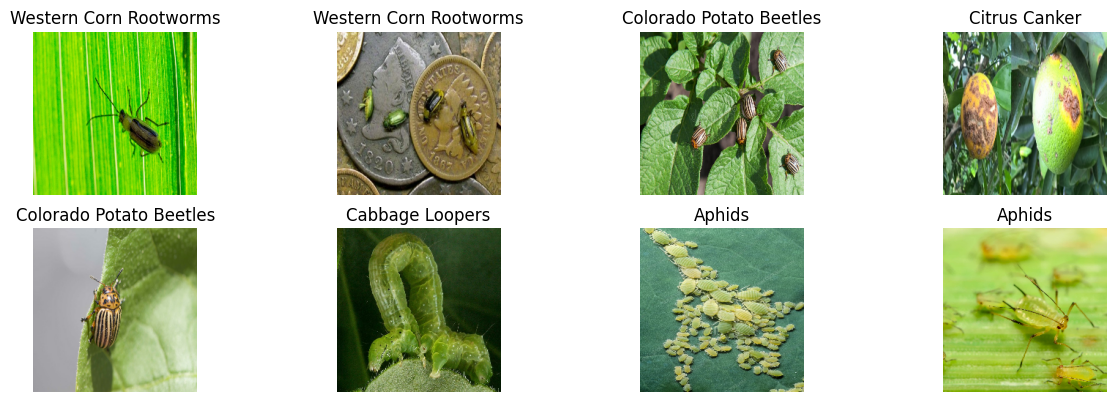

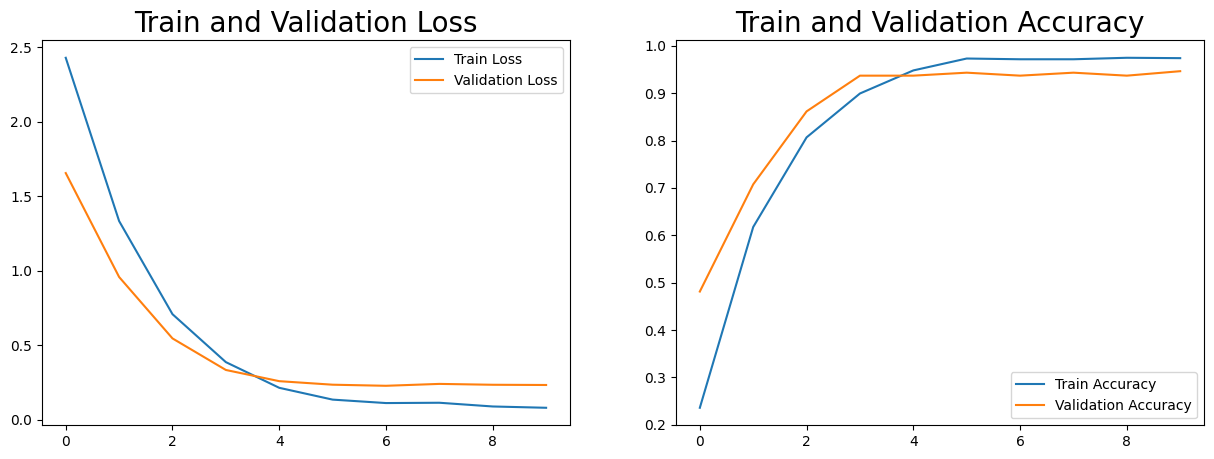

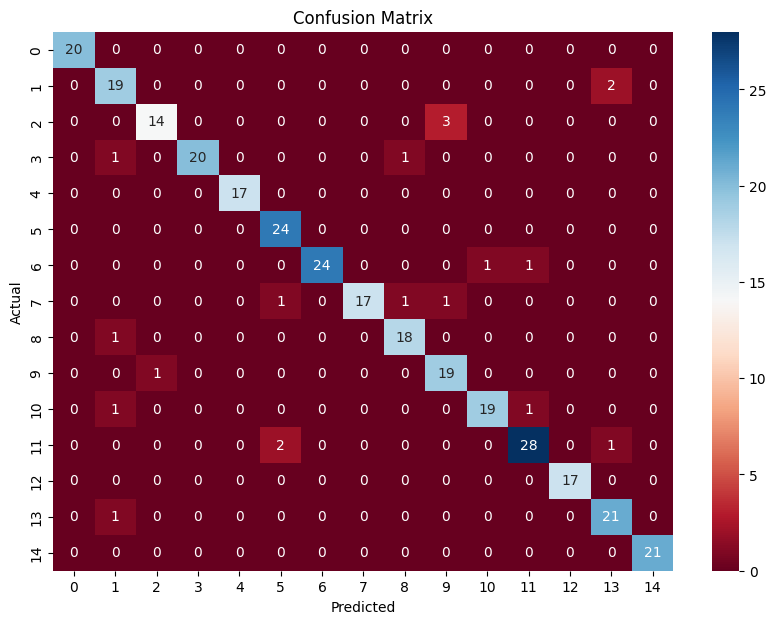

In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


image_data = '/kaggle/input/dangerous-insects-dataset/farm_insects'
batch_size = 32
target_size = (224, 224)
validation_split = 0.2


train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size
)

validation_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size
)


class_names = train_raw.class_names

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


train = train_raw.map(preprocess)
validation = validation_raw.map(preprocess)


def duplicate_inputs(image, label):
    return (image, image), label


train = train.map(duplicate_inputs)
validation = validation.map(duplicate_inputs)


plt.figure(figsize=(15, 20))
for images, labels in train_raw.take(1): 
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


mobilenetv3_base = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
inceptionv3_base = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


mobilenetv3_base.trainable = True
inceptionv3_base.trainable = True


for layer in mobilenetv3_base.layers[:100]:
    layer.trainable = False
for layer in inceptionv3_base.layers[:100]:
    layer.trainable = False


mobilenetv3_output = mobilenetv3_base.output
mobilenetv3_output = layers.GlobalAveragePooling2D()(mobilenetv3_output)

inceptionv3_output = inceptionv3_base.output
inceptionv3_output = layers.GlobalAveragePooling2D()(inceptionv3_output)


concatenated_features = layers.Concatenate()([mobilenetv3_output, inceptionv3_output])


x = layers.Dense(128, activation='relu')(concatenated_features)  
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)


hybrid_model = keras.models.Model(inputs=[mobilenetv3_base.input, inceptionv3_base.input], outputs=output)


hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


y_train = np.concatenate([y for x, y in train_raw], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


hist = hybrid_model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=[early_stopping],
    class_weight=class_weights
)


hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy', fontsize=20)
plt.legend()


X_val, y_val, y_pred = [], [], []
for (img1, img2), labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(img1.numpy())  
predictions = hybrid_model.predict([np.array(X_val), np.array(X_val)])
y_pred = [np.argmax(i) for i in predictions]


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='RdBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
